## Variable selection 3: Sequential Feature Selection

This notebook goes with the blog post: [Variable selection in Python, part I](https://mycarta.wordpress.com/2019/04/30/variable-selection-in-python-part-i/).

### Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn import svm, preprocessing

### Data loading, dropping production

In [2]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv').astype('float64')

### Scaling features

In [3]:
y =  data['Production']
X = data.drop('Production',axis=1)
scaled_X = preprocessing.StandardScaler().fit_transform(X)
scaled_X_df = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)

### Exhaustive Feature Selection with SVM regression

In [4]:
train_X, val_X, train_y, val_y = train_test_split(scaled_X_df, y, test_size= 0.2, random_state=99)

In [5]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [6]:
loo = LeaveOneOut()

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
svrr = svm.SVR(cache_size = 800, epsilon = 0.01)

efs = EFS(estimator=svrr, 
          min_features=1,
          max_features=4, 
          print_progress=False,
          clone_estimator=False, 
          scoring=scorer,
          cv = loo,
          n_jobs = 1)

pipe = Pipeline([('efs', efs), 
                 ('svr', svrr)])

parm_grid={'C': [0.1, 0.5, 1, 3, 5, 7, 9, 11, 13, 15],
            'gamma':[0.0005, 0.0002, 0.0001, 0.001, 0.01, 0.1, 1, 2]}

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=parm_grid,
                           scoring=scorer,
                           cv=loo,
                           verbose=1, 
                           refit=True)

efs = efs.fit(train_X, train_y)

### Plotting results

Plot function modified from:  http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/#example-2-visualizing-the-feature-selection-results

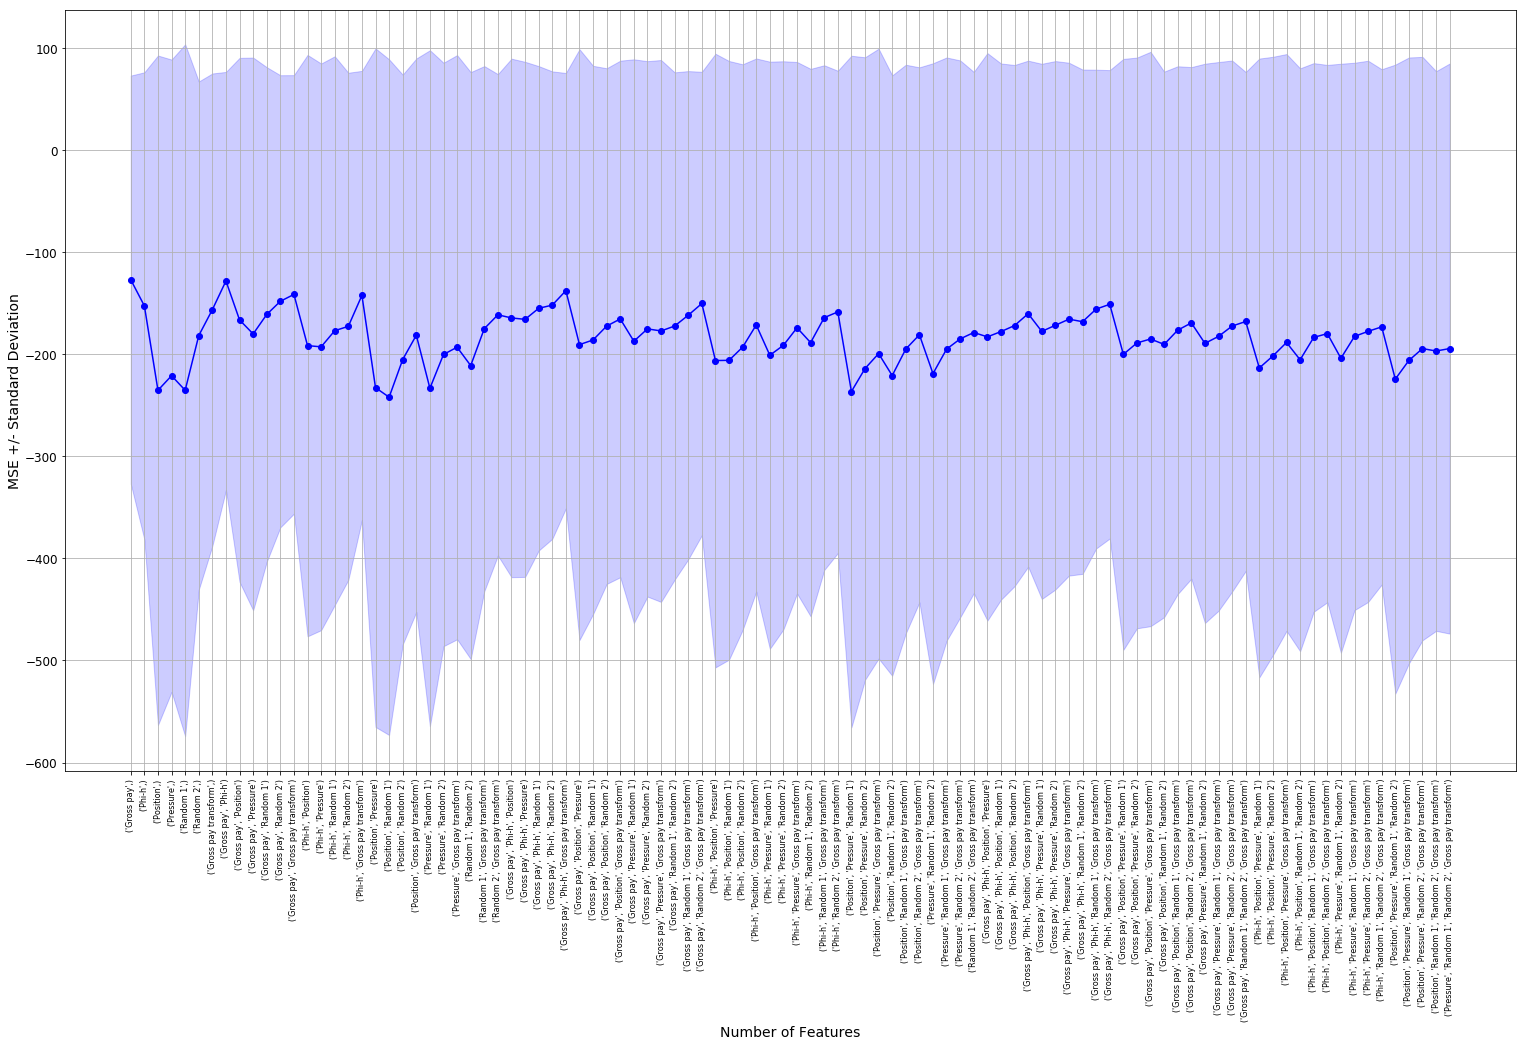

In [9]:
##### Added by Matteo ######
font = {'size'   : 8}
plt.rc('font', **font) 
plt.rc('ytick',labelsize=12)
############################

metric_dict = efs.get_metric_dict()

fig = plt.figure(figsize = (26, 14))
k_feat = sorted(metric_dict.keys())
avg = [metric_dict[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict[k]['avg_score'] +
                 metric_dict[k]['std_dev'])
    lower.append(metric_dict[k]['avg_score'] -
                 metric_dict[k]['std_dev'])

plt.fill_between(k_feat,
                 upper,
                 lower,
                 alpha=0.2,
                 color='blue',
                 lw=1)

plt.plot(k_feat, avg, color='blue', marker='o')
plt.ylabel('MSE +/- Standard Deviation', fontsize=14)
plt.xlabel('Number of Features',  fontsize=14)
feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
plt.xticks(k_feat, 
           [str(metric_dict[k]['feature_names']) for k in k_feat], 
           rotation=90)
plt.grid()
plt.show()


In [10]:
selected_summary = pd.DataFrame.from_dict(efs.get_metric_dict()).T
selected_summary['index'] = selected_summary.index
selected_summary.sort_values(by='avg_score', ascending=0)

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err,index
0,-127.21,109.422,"[-74.22297409474088, -816.108769500775, -70.37...","(0,)","(Gross pay,)",199.911,51.6167,0
7,-128.414,112.046,"[-76.05040970540071, -827.6555457880287, -63.5...","(0, 1)","(Gross pay, Phi-h)",204.704,52.8543,7
32,-137.936,116.688,"[-86.99446293886282, -863.9722918045966, -76.1...","(0, 1, 6)","(Gross pay, Phi-h, Gross pay transform)",213.184,55.0439,32
12,-141.584,117.537,"[-87.67002769258434, -875.399191192731, -82.27...","(0, 6)","(Gross pay, Gross pay transform)",214.736,55.4445,12
17,-142.528,120.33,"[-92.01402886501481, -890.1271518543251, -76.2...","(1, 6)","(Phi-h, Gross pay transform)",219.839,56.7621,17
11,-148.312,121.171,"[-164.9350439608779, -899.5487952834773, -56.0...","(0, 5)","(Gross pay, Random 2)",221.375,57.1587,11
42,-150.481,124.193,"[-139.2223497305132, -923.3189152694708, -63.9...","(0, 5, 6)","(Gross pay, Random 2, Gross pay transform)",226.895,58.5841,42
72,-151.27,125.519,"[-131.32403117756402, -931.0038687711613, -72....","(0, 1, 5, 6)","(Gross pay, Phi-h, Random 2, Gross pay transform)",229.318,59.2098,72
31,-152.062,125.277,"[-145.81666688804796, -927.0605403968333, -67....","(0, 1, 5)","(Gross pay, Phi-h, Random 2)",228.877,59.0957,31
1,-152.77,125.178,"[-103.14106539977855, -935.5071080728405, -63....","(1,)","(Phi-h,)",228.694,59.0487,1


### Obtaining the best k feature 

In [11]:
feature_idx = np.array(selected_summary.loc[0]['feature_idx'])
feature_idx

array([0])

In [12]:
selected = scaled_X_df.iloc[:,feature_idx]
print(list(selected))

['Gross pay']


In [13]:
selected

,Gross pay
0,-1.675028
1,-1.519994
2,-1.364959
3,-1.158247
4,-0.985986
5,-0.848178
6,-0.675917
7,-0.486431
8,-0.296944
9,-0.159136
